In [50]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from numba import njit, cuda
from numpy.typing import NDArray

In [51]:
@cuda.jit
def fitness(individs, points, fitnesses):
    i = cuda.grid(1)

    if i < individs.shape[0]:
        individ = individs[i, :]
        err = 0

        for k in range(points.shape[0]):
            point = points[k, :]
            fun_approx = 0

            for j in range(individ.shape[0]):
                fun_approx += individ[j] * point[0] ** j

            if abs(fun_approx - point[1]) > err:
                err = abs(fun_approx - point[1])

        fitnesses[i] = err

In [52]:
@cuda.jit
def crossover(individs, p_size, children, points, parent1, parent2):
    i = cuda.grid(1)

    if i < p_size:
        p1 = individs[parent1[i], :]
        p2 = individs[parent2[i], :]

        point = points[i]

        c1 = p1[:point]
        c2 = p2[point:]

        for j in range(point):
            children[i, j] = c1[j]
            children[i, point + j] = c2[j]

In [53]:
def mutation(individs):
    mutation_count = random.randint(1, individs.shape[1])

    for i in range(mutation_count):
        index = random.randint(0, individs.shape[0] - 1)
        gen_count = random.randint(1, individs.shape[1])
        gen_max = max(individs[index])

        for j in range(gen_count):
            index2 = random.randint(0, individs.shape[1] - 1)
            individs[index, index2] += np.random.uniform(-gen_max, gen_max)

    return

In [54]:
def genetic_algorithm(points, degree=5, p_size=1000, err=0.001, max_iter=3000, initial = float("inf")):
    population = np.random.random((p_size, degree))
    best_fitness = initial

    points_dev = cuda.to_device(points)

    for i in range(max_iter):
        children = np.zeros((p_size, degree))

        p_dev = cuda.to_device(population[:p_size // 2, :])
        c_dev = cuda.to_device(children)

        crosspoints = [random.randint(1, children.shape[1]) for _ in range(p_size)]
        parent1 = [random.randint(0, p_dev.shape[0] - 1) for _ in range(p_size)]
        parent2 = [random.randint(0, p_dev.shape[0] - 1) for _ in range(p_size)]

        crosspoints_dev = cuda.to_device(crosspoints)
        parent1_dev = cuda.to_device(parent1)
        parent2_dev = cuda.to_device(parent2)

        crossover[int(p_size // 512) + 1, 512](p_dev, p_size, c_dev, crosspoints_dev, parent1_dev, parent2_dev)

        population = c_dev.copy_to_host()

        mutation(population)

        fitnesses = np.zeros(population.shape[0])

        fitnesses_dev = cuda.to_device(fitnesses)

        fitness[int(p_size // 512) + 1, 512](c_dev, points_dev, fitnesses_dev)

        current_fitnesses = fitnesses_dev.copy_to_host()

        population, current_fitnesses = map(np.array, zip(*sorted(zip(population, current_fitnesses), key=lambda x: x[1])))

        if i != 0 and current_fitnesses[0] < best_fitness:
            best_fitness = current_fitnesses[0]
            best_ind = population[0, :]

        if best_fitness < err:
            break

    return best_ind, best_fitness

In [55]:
def generate_data(function, point_count=1000, x_min=-3, x_max=3, std=3):
    x = np.linspace(x_min, x_max, point_count)
    y = function(x) + np.random.random(point_count) * std - std / 2
    return x, y

In [56]:
coeffs = np.random.random(5)
x, y = generate_data(lambda x: coeffs[4] * x ** 4 + coeffs[3] * x ** 3 + coeffs[2] * x ** 2 + coeffs[1] * x + coeffs[0])
print(coeffs)

[0.95106379 0.22075661 0.72327305 0.04503018 0.06248106]


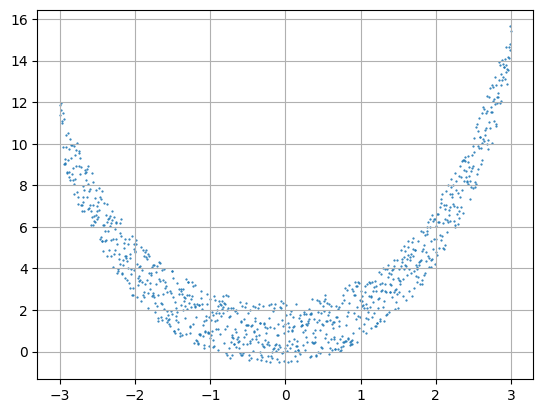

In [57]:
plt.scatter(x, y, s=0.3)
plt.grid()

In [58]:
points = np.hstack([x.reshape(x.shape[0], 1), y.reshape(y.shape[0], 1)], dtype=np.float64)

start = time.time()

params, err = genetic_algorithm(points)

elapsed_time = time.time() - start

print(f"Time: {elapsed_time}s\n"
      f"{params}\n"
      f"{coeffs}")

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Time: 33.4493408203125s
[0.83525751 0.48868269 0.92578751 0.         0.03985434]
[0.95106379 0.22075661 0.72327305 0.04503018 0.06248106]


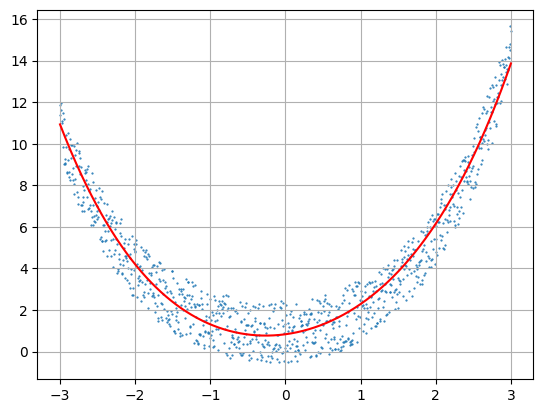

In [59]:
plt.scatter(x, y, s=0.3)
plt.plot(x, params[0] + params[1]*x + params[2]*x**2 + params[3]*x**3 + params[4]*x**4, c='r')
plt.grid()